# Baseline Model

The baseline model is that the recommender which provides the most common/popular items to users.
The most common/popular items is defined by some criterions which will covered afterward.
Before we build the model, we decide to use implicit feedback despite the data contains explicit ratings.
It would be a positive feedback which means 1 if a rating is greater than 3, otherwise 0.

In [21]:
import pickle

import pandas as pd
import numpy as np
from google.cloud import bigquery
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

from utils.metrics import *

In [2]:
def load_data(data: str) -> pd.DataFrame:
    assert data in ["train", "valid", "test"]

    query_string = f"""
        SELECT *
        FROM `qwiklabs-asl-04-5e165f533cac.beer_recom.{data}`
        WHERE review_profilename IS NOT NULL
    """

    bqclient = bigquery.Client()

    return (
        bqclient.query(query_string)
        .result()
        .to_dataframe(
            # Optionally, explicitly request to use the BigQuery Storage API. As of
            # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
            # API is used by default.
            create_bqstorage_client=True,
        )
        .sort_values("review_time", ignore_index=True)
    )

In [3]:
# Download query results.

train = load_data("train")
valid = load_data("valid")
test = load_data("test")

## Baseline Model (The most common/popular items)
### Data Exploration

In [4]:
# The number of users
print("The number of users:", train["review_profilename"].nunique())

# The number of beers in train set
print("The number of beers:", train["beer_name"].nunique())

The number of users: 24214
The number of beers: 43060


<AxesSubplot:>

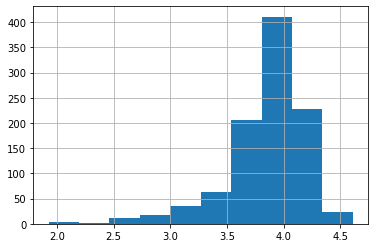

In [5]:
(
    train.groupby(["beer_name"])["review_overall"]
    .agg(["mean", "count"])
    .query("count > 250")
    .reset_index(drop=False)["mean"]
    .hist()
)

In [6]:
# Recommendations with the most common/popular beers would be the baseline model.
# The number of review for each beer should be greater than 250 (10% of users)
# The average ratings should be greater than 4.2 (approximately 100 beers)
most_common_beers = (
    train.groupby(["beer_name"])["review_overall"]
    .agg(["mean", "count"])
    .reset_index(drop=False)
    .query("count >= 250")
    .sort_values("mean", ascending=False, ignore_index=True)
    .query("mean >= 4.2")
)

most_common_beers

,beer_name,mean,count
0,Trappist Westvleteren 12,4.610419,883
1,Pliny The Younger,4.582809,477
2,Portsmouth Kate The Great,4.581597,288
3,Pliny The Elder,4.571666,1507
4,Masala Mama India Pale Ale,4.532101,514
...,...,...,...
89,Siberian Night Imperial Stout,4.211672,574
90,Big Bear Black Stout,4.211233,819
91,Great Lakes Eliot Ness,4.211111,630
92,Fuller's ESB,4.201312,991


### Pre-processing

In [7]:
users = pd.concat(
    [
        train["review_profilename"],
        valid["review_profilename"],
        test["review_profilename"],
    ]
)

#### User/Item Mapping

In [8]:
# Make mappers
def make_mapper(col: str, reverse=False) -> dict:
    arr = pd.concat(
        [
            train[col],
            valid[col],
            test[col],
        ]
    )
    d = arr.drop_duplicates().sort_values(ignore_index=True).to_dict()
    return {v: k for k, v in d.items()} if reverse else d


user_mapper = make_mapper("review_profilename", reverse=True)
item_mapper = make_mapper("beer_name", reverse=True)

In [9]:
def apply_map(df: pd.Series, col: str, mapper: dict) -> pd.Series:
    return df[col].map(mapper)

In [10]:
train["review_profilename"] = apply_map(
    train, "review_profilename", user_mapper
)
train["beer_name"] = apply_map(train, "beer_name", item_mapper)

valid["review_profilename"] = apply_map(
    valid, "review_profilename", user_mapper
)
valid["beer_name"] = apply_map(valid, "beer_name", item_mapper)

test["review_profilename"] = apply_map(test, "review_profilename", user_mapper)
test["beer_name"] = apply_map(test, "beer_name", item_mapper)

In [11]:
most_common_beers["beer_name"] = apply_map(
    most_common_beers, "beer_name", item_mapper
)

### Modeling

In [12]:
train = train[["review_profilename", "beer_name", "review_overall"]].query(
    "review_overall >= 3"
)
valid = valid[["review_profilename", "beer_name", "review_overall"]].query(
    "review_overall >= 3"
)
test = test[["review_profilename", "beer_name", "review_overall"]].query(
    "review_overall >= 3"
)

In [13]:
train_mat = np.zeros((len(user_mapper), len(item_mapper)))
valid_mat = np.zeros((len(user_mapper), len(item_mapper)))
test_mat = np.zeros((len(user_mapper), len(item_mapper)))
pred_mat = np.zeros((len(user_mapper), len(item_mapper)))

In [14]:
for _, user, item, rating in tqdm(train.itertuples(), total=len(train)):
    train_mat[user, item] = rating

for _, user, item, rating in tqdm(valid.itertuples(), total=len(valid)):
    valid_mat[user, item] = rating

for _, user, item, rating in tqdm(test.itertuples(), total=len(test)):
    test_mat[user, item] = rating

  0%|          | 0/1022381 [00:00<?, ?it/s]

  0%|          | 0/220993 [00:00<?, ?it/s]

  0%|          | 0/222265 [00:00<?, ?it/s]

In [15]:
for _, item, mean, count in tqdm(
    most_common_beers.itertuples(), total=len(most_common_beers)
):
    pred_mat[:, item] = mean

# Remove the-already-seen-items by masking
pred_mat[train_mat > 0] = -np.inf

# Only consider users that are contained in test set.
test_users = test["review_profilename"].unique()
pred_mat = pred_mat[test_users]
test_mat = test_mat[test_users]

  0%|          | 0/94 [00:00<?, ?it/s]

In [16]:
# Users that did not make any review during test period are excluded from the scoring.
map_at_10 = map_at_k(actual=test_mat, pred=pred_mat, top_k=10)

print(f"MAP@10 for baseline: {map_at_10:.6f}")

  0%|          | 0/9085 [00:00<?, ?it/s]

MAP@10 for baseline: 0.044275


### Save data for other models

In [18]:
train.to_parquet("./data/train.parquet")
valid.to_parquet("./data/valid.parquet")
test.to_parquet("./data/test.parquet")

In [22]:
with open("./data/user_mapper.dict", "wb") as f:
    pickle.dump(user_mapper, f)
with open("./data/item_mapper.dict", "wb") as f:
    pickle.dump(item_mapper, f)

In [41]:
# Sync Github Done
# https://github.com/gitsongsang/asl_team1